# Bootstraping

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.utils import resample

In [19]:
# Upload data
data = pd.read_csv('/Users/fernandaamartel/Downloads/penn_jae.csv')

In [20]:
# Print data
print(data.head())

   Unnamed: 0   abdt  tg  inuidur1  inuidur2  female  black  hispanic  \
0           1  10824   0        18        18       0      0         0   
1           2  10635   2         7         3       0      0         0   
2           3  10551   5        18         6       1      0         0   
3           4  10824   0         1         1       0      0         0   
4           5  10747   0        27        27       0      0         0   

   othrace  dep  ...  q5  q6  recall  agelt35  agegt54  durable  nondurable  \
0        0    2  ...   1   0       0        0        0        0           0   
1        0    0  ...   0   0       0        1        0        0           0   
2        0    0  ...   0   0       1        0        1        0           0   
3        0    0  ...   1   0       0        0        0        0           0   
4        0    0  ...   0   0       0        0        0        0           0   

   lusd  husd  muld  
0     0     1     0  
1     1     0     0  
2     0     0     0 

In [21]:
# Print data columns
print(data.columns)

Index(['Unnamed: 0', 'abdt', 'tg', 'inuidur1', 'inuidur2', 'female', 'black',
       'hispanic', 'othrace', 'dep', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6',
       'recall', 'agelt35', 'agegt54', 'durable', 'nondurable', 'lusd', 'husd',
       'muld'],
      dtype='object')


In [22]:
# Filter data to keep rows where tg == 0 and or tg == 4
filtered_data = data[data['tg'].isin([0, 4])].copy()

In [23]:
# Create T4 Variable
filtered_data['T4'] = (filtered_data['tg'].isin([0, 4])).astype(int)

In [24]:
# Print new data
print(filtered_data.head())
print(filtered_data.shape)

    Unnamed: 0   abdt  tg  inuidur1  inuidur2  female  black  hispanic  \
0            1  10824   0        18        18       0      0         0   
3            4  10824   0         1         1       0      0         0   
4            5  10747   0        27        27       0      0         0   
11          12  10607   4         9         9       0      0         0   
12          13  10831   0        27        27       0      0         0   

    othrace  dep  ...  q6  recall  agelt35  agegt54  durable  nondurable  \
0         0    2  ...   0       0        0        0        0           0   
3         0    0  ...   0       0        0        0        0           0   
4         0    0  ...   0       0        0        0        0           0   
11        0    0  ...   0       0        1        0        0           0   
12        0    1  ...   0       0        0        1        1           0   

    lusd  husd  muld  T4  
0      0     1     0   1  
3      1     0     0   1  
4      1     0   

In [25]:
# Define formula
formula = 'np.log(inuidur1) ~ T4 + female + black + othrace + C(dep) + q2 + q3 + q4 + q5 + q6 + agelt35 + agegt54 + durable + lusd + husd'

In [26]:
# Define model 
def fit_model(data):
    model = sm.formula.ols(formula=formula, data=data).fit()
    return model.params[['T4', 'female', 'black']]

In [27]:
# 1000 bootstrap estimates
n_iterations = 1000

In [28]:
# Seed to ensure reproducibility
np.random.seed(28)

In [29]:
# Bootstrap estimates
bootstrap_estimates = []

for _ in range(n_iterations):
    # Resample
    boot_sample = resample(filtered_data)
    # Fit the model to get coefficients
    coefs = fit_model(boot_sample)
    bootstrap_estimates.append(coefs)

In [32]:
# Convert to dataframe
bootstrap_estimates = pd.DataFrame(bootstrap_estimates)

In [33]:
# Compute standard errors
standard_errors = bootstrap_estimates.std()

In [34]:
# Storing coefficients and standard errors
result_table = pd.DataFrame({
    'Coefficient': bootstrap_estimates.mean(),
    'Standard Error': standard_errors
})

In [35]:
# Display table
print(result_table)

         Coefficient  Standard Error
T4      2.876809e+10    2.426455e+12
female  1.279056e-01    3.389558e-02
black  -2.941713e-01    5.973296e-02


# Causal forest

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("C:/Users/Frank/Downloads/synthetic_data.csv")
df.head(5)

,schoolid,Z,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
0,76,1,0.081602,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,76,1,-0.385869,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,76,1,0.398184,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,76,1,-0.175037,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,76,1,0.884583,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757


In [2]:
df.rename(columns={'Z': 'D'}, inplace=True)


X: list[str] = ['S3', 'C1', 'C2', 'C3','XC','X1','X2','X3','X4','X5', ]
D: str = 'D'
Y: list[str] = ['Y']

In [3]:
from sklearn.linear_model import LogisticRegression
df['pscore'] = LogisticRegression().fit(df[X], df.D).predict_proba(df[X])[:,1]
#df['pscore'] = LogisticRegression().fit(df[X], df[dgp.D]).predict_proba(df[X])[:,1]
df['y_star'] = df.Y / (df.D * df['pscore'] - (1-df.D) * (1-df['pscore']))
#df['y_star'] = df[dgp.Y[0]] / (df[dgp.D] * df['pscore'] - (1-df[dgp.D]) * (1-df['pscore']))

In [4]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=2).fit(df[X], df['y_star'])
df['y_hat'] = tree.predict(df[X])

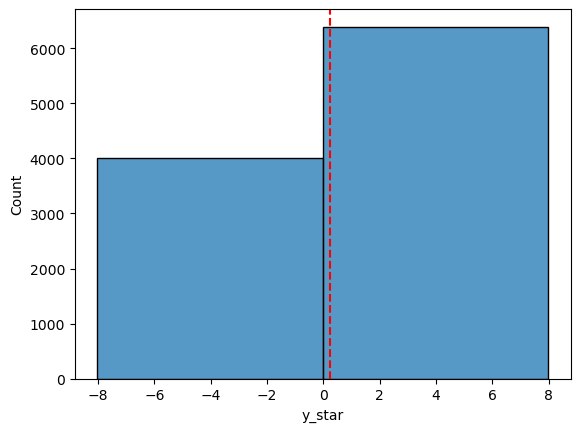

In [5]:
sns.histplot(data=df, x='y_star', binwidth= 8)
plt.axvline(x=df['y_star'].mean(), color='red', linestyle='--')

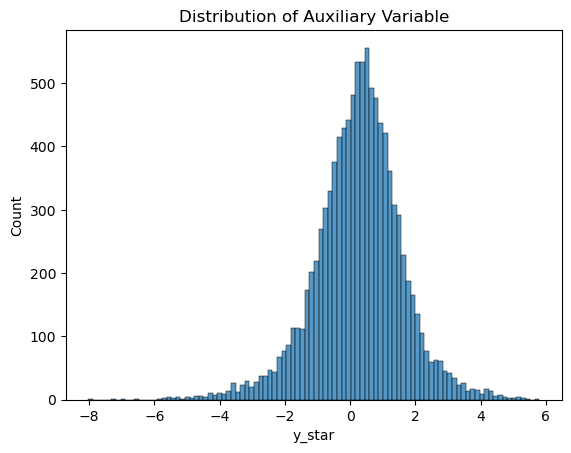

In [6]:
sns.histplot(df['y_star']).set(title='Distribution of Auxiliary Variable');

In [7]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=2).fit(df[X], df['y_star'])
df['y_hat'] = tree.predict(df[X])

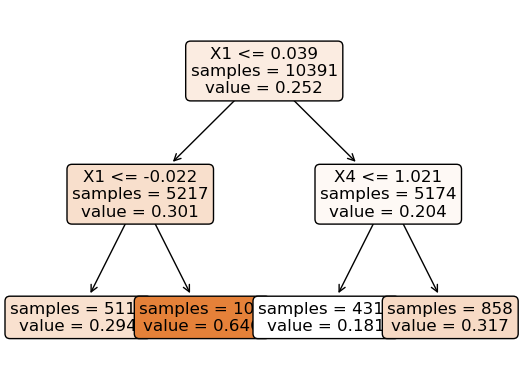

In [8]:
from sklearn.tree import plot_tree

plot_tree(tree, filled=True, fontsize=12, feature_names=X, impurity=False, rounded=True);

In [9]:
df[Y]

,Y
0,0.081602
1,-0.385869
2,0.398184
3,-0.175037
4,0.884583
...,...
10386,0.423366
10387,-0.197092
10388,0.141698
10389,-0.351565


In [10]:
df[X]

,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
0,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
...,...,...,...,...,...,...,...,...,...,...
10386,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10387,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10388,2,15,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10389,5,4,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702


In [11]:
df.D

0        1
1        1
2        1
3        1
4        1
        ..
10386    0
10387    0
10388    0
10389    0
10390    0
Name: D, Length: 10391, dtype: int64

In [12]:
from econml.dml import CausalForestDML
tree_model = CausalForestDML(n_estimators=1, subforest_size=1, inference=False, max_depth=2)
tree_model = tree_model.fit(Y=df.Y, X=df[X], T=df.D)

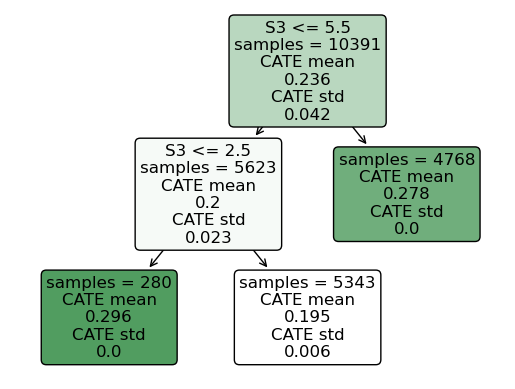

In [13]:
from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(tree_model, df[X])
intrp.plot(feature_names=X, fontsize=12)

In [16]:
def compute_discrete_effects(df, hte_model):
    temp_df = df.copy()
    temp_df.time = 0
    #temp_df = dgp.add_treatment_effect(temp_df)
    
    effect = 7*np.exp(-(df.S3-18)**2/100) + 7*np.exp(-(df.C1-18)**2/100) + 7*np.exp(-(df.C2-18)**2/100) + 7*np.exp(-(df.C3-18)**2/100)
    df['effect_on_spend'] = np.maximum(0, effect)
    
    temp_df = temp_df.rename(columns={'effect_on_spend': 'True'})
    temp_df['Predicted'] = hte_model.effect(temp_df[X])
    df_effects = pd.DataFrame()
    for var in X[1:]:
        for effect in ['True', 'Predicted']:
            v = temp_df[effect][temp_df[var]==1].mean() - temp_df[effect][temp_df[var]==0].mean()
            effect_var = {'Variable': [var], 'Effect': [effect], 'Value': [v]}
            df_effects = pd.concat([df_effects, pd.DataFrame(effect_var)]).reset_index(drop=True)
    return df_effects, temp_df['Predicted'].mean()

df_effects_tree, avg_effect_notime_tree = compute_discrete_effects(df, tree_model)

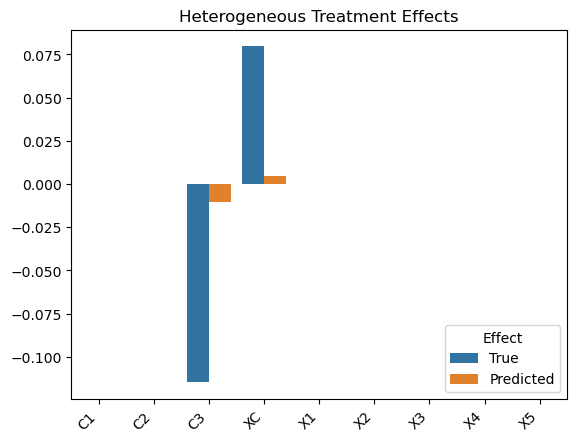

In [17]:
fig, ax = plt.subplots()
sns.barplot(data=df_effects_tree, x="Variable", y="Value", hue="Effect", ax=ax).set(
    xlabel='', ylabel='', title='Heterogeneous Treatment Effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

In [18]:
df_time = df.copy()
df_time[[X[1:]] + ['S3', 'C1', 'C2', 'C3']] = 0

df_time

,schoolid,D,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5,pscore,y_star,y_hat,effect_on_spend
0,76,1,0.081602,0,0,0,0,0,0,0,0,0,0,0.309228,0.263888,0.181408,3.574670
1,76,1,-0.385869,0,0,0,0,0,0,0,0,0,0,0.263671,-1.463451,0.181408,6.799910
2,76,1,0.398184,0,0,0,0,0,0,0,0,0,0,0.339107,1.174213,0.181408,3.459784
3,76,1,-0.175037,0,0,0,0,0,0,0,0,0,0,0.339107,-0.516170,0.181408,3.459784
4,76,1,0.884583,0,0,0,0,0,0,0,0,0,0,0.361239,2.448747,0.181408,3.307684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,1,0,0.423366,0,0,0,0,0,0,0,0,0,0,0.323433,-0.625756,0.181408,4.003557
10387,1,0,-0.197092,0,0,0,0,0,0,0,0,0,0,0.323433,0.291312,0.181408,4.003557
10388,1,0,0.141698,0,0,0,0,0,0,0,0,0,0,0.235489,-0.185345,0.181408,7.716718
10389,1,0,-0.351565,0,0,0,0,0,0,0,0,0,0,0.300468,0.502571,0.181408,3.055713


In [19]:
def compute_time_effect(df, hte_model, avg_effect_notime):
    df_time = df.copy()
    df_time[[X[1:]] + ['device', 'browser', 'region']] = 0
    #df_time = dgp.add_treatment_effect(df_time)
    effect = 7*np.exp(-(df.S3-18)**2/100) + 7*np.exp(-(df.C1-18)**2/100) + 7*np.exp(-(df.C2-18)**2/100) + 7*np.exp(-(df.C3-18)**2/100)
    df['effect_on_spend'] = np.maximum(0, effect)
    
    df_time['predicted'] = hte_model.effect(df_time[X]) + avg_effect_notime
    return df_time

df_time_tree = compute_time_effect(df, tree_model, avg_effect_notime_tree)

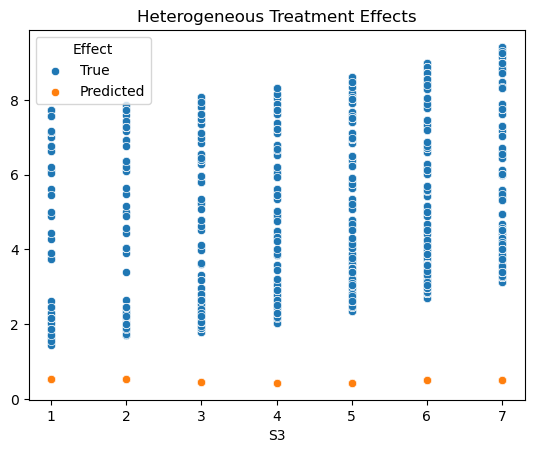

In [20]:
sns.scatterplot( x='S3', y='effect_on_spend', data=df_time_tree, label='True' )
sns.scatterplot(x='S3', y='predicted', data=df_time_tree, label='Predicted').set(
    ylabel='', title='Heterogeneous Treatment Effects')
plt.legend(title='Effect');

In [32]:
forest_model.feature_importances()

array([0.54659156, 0.02032399, 0.00178681, 0.00374974, 0.02161981,
       0.10372525, 0.06494957, 0.01599999, 0.04052054, 0.18073275])

In [22]:
np.random.seed(0)
from econml.dml import CausalForestDML


forest_model = CausalForestDML(max_depth=3, n_estimators =100)
forest_model = forest_model.fit(Y=df.Y, X=df[X], T=df.D)

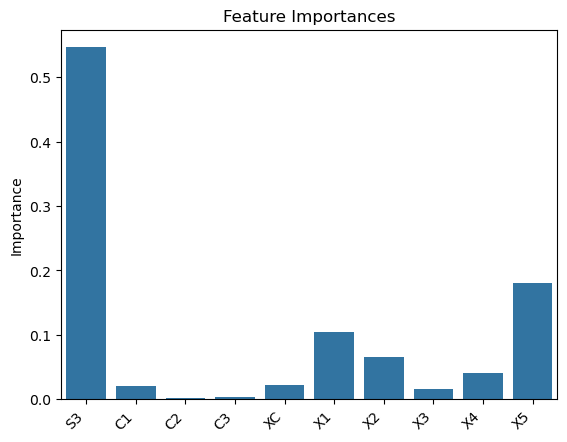

In [23]:
fig, ax = plt.subplots()
sns.barplot(x=X, y=forest_model.feature_importances(), color='C0').set(
    title='Feature Importances', ylabel='Importance')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

In [24]:
def compute_discrete_effects(df, hte_model):
    temp_df = df.copy()
    temp_df.S3 = 0
    #temp_df = dgp.add_treatment_effect(temp_df)
    effect = 7*np.exp(-(df.S3-18)**2/100) + 7*np.exp(-(df.C1-18)**2/100) + 7*np.exp(-(df.C2-18)**2/100) + 7*np.exp(-(df.C3-18)**2/100)
    df['effect_on_spend'] = np.maximum(0, effect)
    
    
    temp_df = temp_df.rename(columns={'effect_on_spend': 'True'})
    temp_df['Predicted'] = hte_model.effect(temp_df[X])
    df_effects = pd.DataFrame()
    for var in X[1:]:
        for effect in ['True', 'Predicted']:
            v = temp_df.loc[temp_df[var]==1, effect].mean() - temp_df[effect][temp_df[var]==0].mean()
            effect_var = {'Variable': [var], 'Effect': [effect], 'Value': [v]}
            df_effects = pd.concat([df_effects, pd.DataFrame(effect_var)]).reset_index(drop=True)
    return df_effects, temp_df['Predicted'].mean()

df_effects, avg_effect_notime = compute_discrete_effects(df, forest_model)

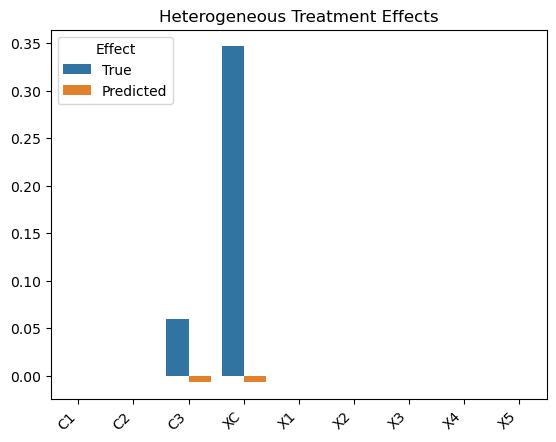

In [28]:
fig, ax = plt.subplots()
sns.barplot(data=df_effects, x="Variable", y="Value", hue="Effect", ax=ax).set(
    xlabel='', ylabel='', title='Heterogeneous Treatment Effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

In [29]:
def compute_time_effect(df, hte_model, avg_effect_notime):
    df_time = df.copy()
    df_time[[X[1:]] + ['device', 'browser', 'region']] = 0
    #df_time = dgp.add_treatment_effect(df_time)
    effect = 7*np.exp(-(df.S3-18)**2/100) + 7*np.exp(-(df.C1-18)**2/100) + 7*np.exp(-(df.C2-18)**2/100) + 7*np.exp(-(df.C3-18)**2/100)
    df['effect_on_spend'] = np.maximum(0, effect)
    
    
    df_time['predicted'] = hte_model.effect(df_time[X]) + avg_effect_notime
    return df_time

df_time = compute_time_effect(df, forest_model, avg_effect_notime)

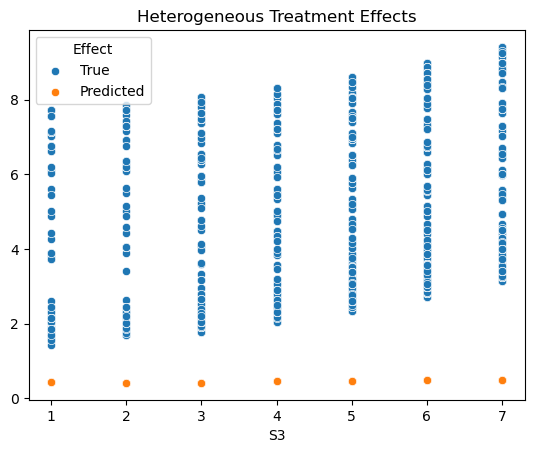

In [31]:
sns.scatterplot(x='S3', y='effect_on_spend', data=df_time, label='True')
sns.scatterplot(x='S3', y='predicted', data=df_time, label='Predicted').set(
    ylabel='', title='Heterogeneous Treatment Effects')
plt.legend(title='Effect');

### 1. How the tree was built?

First they define the predictor, treatment, and outcome variables. Then, they predict the treatment variable, followed by building two separate random forest models to predict the outcome and treatment variables. After that, they construct a causal forest model considering all predictors (raw cf), and a final causal forest model using the most imporntat predictors (cf).

### 2. Estimate ATE

The ATE is found with the "average_treatment_effect" function, this is the average effect of the paper intervention.

### 3. Run best linear predictor analysis

In this part, multiple test are done in order to find the best fit model.
The results indicate that the mean forest predictions are a significant predictor of the treatment effect, no significant difference in the Average Treatment Effect (ATE) between regions as the difference is 0.054 with a 95% confidence interval of ± 0.07. For the predictor X1, there is a significant difference in school scores between high and low levels. X2 does not show a significant difference in school scores between high and low levels. An ANOVA test for different levels of X2 also shows no significant differences in school scores

### 4.Look at school-wise heterogeneity

We can see that the distribution of school.score isnt normal and has a strong bias. After that, the student expectation of success is expected (with the cf) to positively affect the propensity score, but we see that there are many values that do not adjust (more in 6 and 7).

### 5. Analysis ignoring clusters. How do the results change?

ATE goes from 0.247 +/- 0.039' to 0.253 +/- 0.022, reducing the confidence interval signicantly.

### 7. The code plot six plots in the Make some plots section, so explain what you find there.

The first two estimated CATE have less variance than the no-propensity score one. X1 and X2 show good fits, but x1 has more atypical values.

### 8. Visualize school-level covariates by treatment heterogeneity

Low X2, high X5 and low XC.3 show the biggest means. On the other hand, low X2, low X5 and high-mid show the lowest ones.

### 9. CATE by school

Most of the schools show low difference from the mean, but there are many extreme values at the right of the graph.